In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



import geopandas 
import descartes
from datetime import datetime
from shapely import wkt
from shapely.geometry import Point, Polygon

import bokeh.plotting as bp
import bokeh.models as bm
import bokeh.layouts as bl
import bokeh.models.widgets as bmw
from bokeh.palettes import brewer
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.resources import CDN, INLINE




%matplotlib inline

In [32]:
bp.output_notebook(INLINE)

Loading BokehJS ...

In [33]:
airport_traffic = pd.read_csv('covid_impact_on_airport_traffic.csv', index_col=0, parse_dates=['Date'])

In [34]:
airport_traffic.head()

Date  Version      AirportName  PercentOfBaseline  \
AggregationMethod                                                           
Daily             2020-07-05      1.0  Kingsford Smith                 52   
Daily             2020-05-28      1.0  Kingsford Smith                 61   
Daily             2020-05-07      1.0  Kingsford Smith                 62   
Daily             2020-06-24      1.0  Kingsford Smith                 58   
Daily             2020-08-05      1.0  Kingsford Smith                 20   

                                                    Centroid    City  \
AggregationMethod                                                      
Daily              POINT(151.180087713813 -33.9459774986125)  Sydney   
Daily              POINT(151.180087713813 -33.9459774986125)  Sydney   
Daily              POINT(151.180087713813 -33.9459774986125)  Sydney   
Daily              POINT(151.180087713813 -33.9459774986125)  Sydney   
Daily              POINT(151.180087713813 -33.9459774986125)  Sydney   

                             State ISO_3166_2    Country  \
AggregationMethod                                          
Daily              New South Wales         AU  Australia   
Daily              New South Wales         AU  Australia   
Daily              New South Wales         AU  Australia   
Daily              New South Wales         AU  Australia   
Daily              New South Wales         AU  Australia   

                                                           Geography  
AggregationMethod                                                     
Daily              POLYGON((151.164354085922 -33.9301772341877, 1...  
Daily              POLYGON((151.164354085922 -33.9301772341877, 1...  
Daily              POLYGON((151.164354085922 -33.9301772341877, 1...  
Daily              POLYGON((151.164354085922 -33.9301772341877, 1...  
Daily              POLYGON((151.164354085922 -33.9301772341877, 1...

In [35]:
uniq_cities = airport_traffic['City'].unique()
uniq_states = airport_traffic['State'].unique()

In [36]:
uniq_states

array(['New South Wales', 'Santiago Province', 'Alberta',
       'British Columbia', 'Manitoba', 'Nova Scotia', 'Ontario', 'Quebec',
       'California', 'Colorado', 'Florida', 'Georgia', 'Hawaii',
       'Illinois', 'Massachusetts', 'Michigan', 'North Carolina',
       'New Jersey', 'Nevada', 'New York', 'Texas', 'Virginia',
       'Washington'], dtype=object)

In [37]:
uniq_cities

array(['Sydney', 'Santiago', 'Calgary', 'Leduc County', 'Richmond',
       'Winnipeg', 'Halifax', 'Mississauga', 'Hamilton', 'Mirabel',
       'Dorval', 'Los Angeles', 'South San Francisco', 'Denver',
       'Miami Springs', 'College Park', 'Urban Honolulu', 'Chicago',
       'Boston', 'Romulus', 'Charlotte', 'Newark', 'Paradise', 'New York',
       'Grapevine', 'Floris', 'SeaTac'], dtype=object)

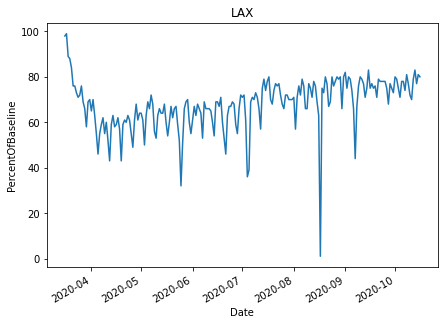

In [38]:
city = 'Los Angeles'
la_air = airport_traffic[airport_traffic['City']=='Los Angeles']
fig = plt.figure(figsize=(7,5))
la = sns.lineplot(x=la_air['Date'], y=la_air['PercentOfBaseline'])
fig.autofmt_xdate()
plt.title('LAX');

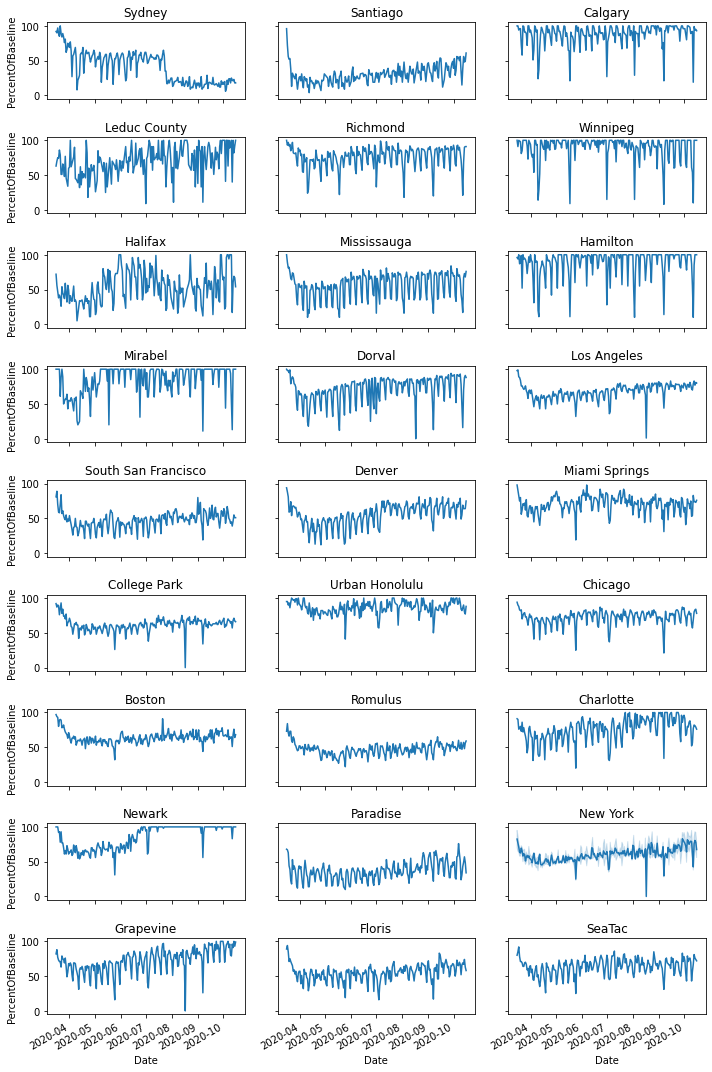

In [39]:
fig, axs = plt.subplots(9, 3, figsize=(10,15), sharey=True)
axes = axs.ravel()
for (i,ax) in enumerate(axes):
    city = uniq_cities[i]
    city_air = airport_traffic[airport_traffic['City']==city]
    sns.lineplot(ax=ax, x=city_air['Date'], y=city_air['PercentOfBaseline'])
    fig.autofmt_xdate()
    ax.set_title(city);
    
plt.tight_layout()

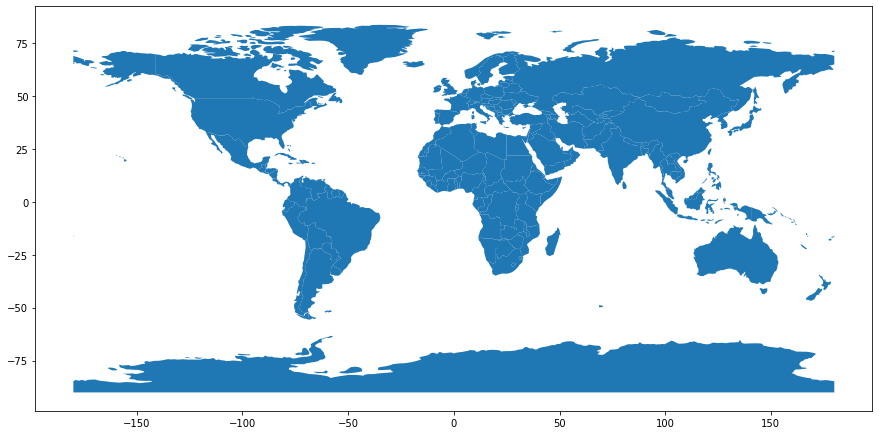

In [40]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(15,15))

In [41]:
airport_traffic['Geography'] = airport_traffic['Geography'].apply(wkt.loads)
airport_traffic['Centroid'] = airport_traffic['Centroid'].apply(wkt.loads)

In [42]:
loc = airport_traffic['ISO_3166_2']
US_traffic = airport_traffic[loc.str.startswith('US') & ~loc.str.contains('HI')]

(-127.62123008435083,
 -64.09431570330703,
 23.271419647136472,
 50.628175494194934)

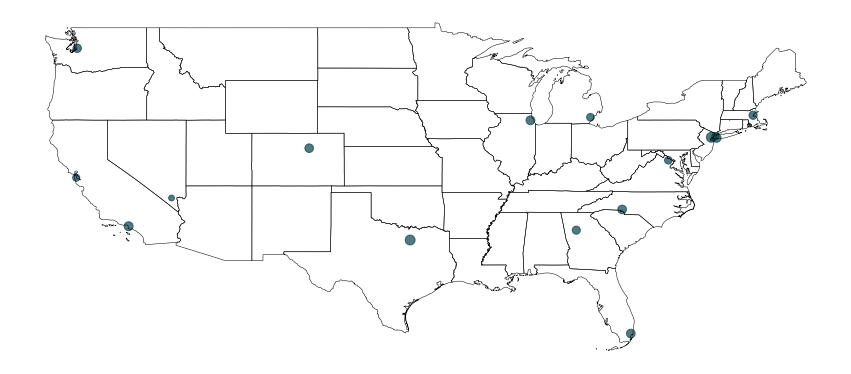

In [43]:
sgeo = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/states-10m.json')
sgeo = sgeo[~sgeo.name.isin([
    'Alaska','Hawaii', 'American Samoa', 'Puerto Rico', 'Guam',
    'Commonwealth of the Northern Mariana Islands',
    'United States Virgin Islands'])]
# sgeo['geometry'] = sgeo.geometry.scale(yfact=-1, origin=(0,0))
fig, ax = plt.subplots(figsize=(15,15))
a_df = US_traffic[US_traffic['Date'] == US_traffic['Date'].max()]
gdf = geopandas.GeoDataFrame(a_df, geometry=a_df['Centroid'])
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['Centroid']

sgeo.boundary.plot(ax=ax,  color='k', lw=.5)
gdf.plot(ax=ax, color="#07424A", markersize="PercentOfBaseline",alpha=0.7, categorical=False, legend=True)

# gdf_points.plot(ax=ax,color="#07424A", markersize="PercentOfBaseline",alpha=0.7, categorical=False, legend=True )
ax.axis("off")


In [44]:
lldf = pd.DataFrame(dict(
    longs = [c.x for c in US_traffic['Centroid']],
    lats = [c.y for c in US_traffic['Centroid']]
))
ll = pd.DataFrame(dict(
    longs = [c.x for c in gdf['Centroid']],
    lats = [c.y for c in gdf['Centroid']]
))

US_traffic['lats'] = lldf['lats'].values
US_traffic['longs'] = lldf['longs'].values

<ipython-input-44-5e2050e6ea4e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_traffic['lats'] = lldf['lats'].values
<ipython-input-44-5e2050e6ea4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_traffic['longs'] = lldf['longs'].values


In [45]:
US_traffic

Date  Version                    AirportName  \
AggregationMethod                                                      
Daily             2020-05-06      1.0      Los Angeles International   
Daily             2020-07-04      1.0      Los Angeles International   
Daily             2020-09-24      1.0      Los Angeles International   
Daily             2020-10-05      1.0      Los Angeles International   
Daily             2020-07-30      1.0      Los Angeles International   
...                      ...      ...                            ...   
Daily             2020-06-15      1.0  Seattle-Tacoma International    
Daily             2020-10-15      1.0  Seattle-Tacoma International    
Daily             2020-04-01      1.0  Seattle-Tacoma International    
Daily             2020-05-12      1.0  Seattle-Tacoma International    
Daily             2020-10-11      1.0  Seattle-Tacoma International    

                   PercentOfBaseline  \
AggregationMethod                      
Daily                             66   
Daily                             36   
Daily                             78   
Daily                             78   
Daily                             70   
...                              ...   
Daily                             64   
Daily                             74   
Daily                             65   
Daily                             65   
Daily                             57   

                                                     Centroid         City  \
AggregationMethod                                                            
Daily               POINT (-118.404993180627 33.941369379328)  Los Angeles   
Daily               POINT (-118.404993180627 33.941369379328)  Los Angeles   
Daily               POINT (-118.404993180627 33.941369379328)  Los Angeles   
Daily               POINT (-118.404993180627 33.941369379328)  Los Angeles   
Daily               POINT (-118.404993180627 33.941369379328)  Los Angeles   
...                                                       ...          ...   
Daily              POINT (-122.308661576118 47.4505828917119)       SeaTac   
Daily              POINT (-122.308661576118 47.4505828917119)       SeaTac   
Daily              POINT (-122.308661576118 47.4505828917119)       SeaTac   
Daily              POINT (-122.308661576118 47.4505828917119)       SeaTac   
Daily              POINT (-122.308661576118 47.4505828917119)       SeaTac   

                        State ISO_3166_2                         Country  \
AggregationMethod                                                          
Daily              California      US-CA  United States of America (the)   
Daily              California      US-CA  United States of America (the)   
Daily              California      US-CA  United States of America (the)   
Daily              California      US-CA  United States of America (the)   
Daily              California      US-CA  United States of America (the)   
...                       ...        ...                             ...   
Daily              Washington      US-WA  United States of America (the)   
Daily              Washington      US-WA  United States of America (the)   
Daily              Washington      US-WA  United States of America (the)   
Daily              Washington      US-WA  United States of America (the)   
Daily              Washington      US-WA  United States of America (the)   

                                                           Geography  \
AggregationMethod                                                      
Daily              POLYGON ((-118.439612388611 33.9517616366508, ...   
Daily              POLYGON ((-118.439612388611 33.9517616366508, ...   
Daily              POLYGON ((-118.439612388611 33.9517616366508, ...   
Daily              POLYGON ((-118.439612388611 33.9517616366508, ...   
Daily              POLYGON ((-118.439612388611 33.9517616366508, ...   
...                                                       

In [46]:
sgeo

id                  name  \
0   01               Alabama   
2   04               Arizona   
3   08              Colorado   
4   12               Florida   
5   13               Georgia   
6   18               Indiana   
7   20                Kansas   
8   23                 Maine   
9   25         Massachusetts   
10  27             Minnesota   
11  34            New Jersey   
12  37        North Carolina   
13  38          North Dakota   
14  40              Oklahoma   
15  42          Pennsylvania   
16  46          South Dakota   
17  48                 Texas   
18  56               Wyoming   
19  09           Connecticut   
20  29              Missouri   
21  54         West Virginia   
22  17              Illinois   
23  35            New Mexico   
24  05              Arkansas   
25  06            California   
26  10              Delaware   
27  11  District of Columbia   
29  19                  Iowa   
30  21              Kentucky   
31  24              Maryland   
32  26              Michigan   
33  28           Mississippi   
34  30               Montana   
35  33         New Hampshire   
36  36              New York   
37  39                  Ohio   
38  41                Oregon   
39  47             Tennessee   
40  49                  Utah   
41  51              Virginia   
42  53            Washington   
43  55             Wisconsin   
47  31              Nebraska   
48  45        South Carolina   
51  16                 Idaho   
52  32                Nevada   
53  50               Vermont   
54  22             Louisiana   
55  44          Rhode Island   

                                             geometry  
0   MULTIPOLYGON (((-88.33102 30.23539, -88.13002 ...  
2   POLYGON ((-114.71951 32.71893, -114.70157 32.7...  
3   POLYGON ((-109.04843 41.00026, -108.17982 41.0...  
4   MULTIPOLYGON (((-80.75043 24.85767, -80.70018 ...  
5   POLYGON ((-85.60675 34.98427, -85.46677 34.982...  
6   POLYGON ((-87.52343 41.70813, -87.46959 41.672...  
7   POLYGON ((-102.05289 40.00290, -101.13045 40.0...  
8   MULTIPOLYGON (((-68.37096 44.19339, -68.32071 ...  
9   MULTIPOLYGON (((-70.27687 41.31038, -70.23021 ...  
10  POLYGON ((-97.22888 49.00069, -96.93097 48.999...  
11  POLYGON ((-75.56032 39.63006, -75.51007 39.685...  
12  MULTIPOLYGON (((-75.72542 35.93611, -75.66082 ...  
13  POLYGON ((-104.04854 48.99983, -103.37375 48.9...  
14  POLYGON ((-103.00047 37.00048, -102.77793 36.9...  
15  POLYGON ((-80.52072 41.97787, -80.34843 42.030...  
16  POLYGON ((-104.05931 44.99747, -104.04136 45.0...  
17  POLYGON ((-103.00406 36.50051, -102.25031 36.5...  
18  POLYGON ((-104.05931 44.99747, -104.05572 44.8...  
19  POLYGON ((-73.48570 42.05003, -73.43186 42.050...  
20  POLYGON ((-95.76445 40.58534, -95.16504 40.577...  
21  POLYGON ((-82.59533 38.42223, -82.53072 38.405...  
22  POLYGON ((-91.41782 40.37830, -91.37474 40.392...  
23  POLYGON ((-109.04484 36.99876, -108.24802 36.9...  
24  POLYGON ((-94.61947 36.49965, -93.86571 36.498...  
25  MULTIPOLYGON (((-118.60313 33.47834, -118.5457...  
26  MULTIPOLYGON (((-75.79003 39.72198, -75.71824 ...  
27  POLYGON ((-77.11807 38.93423, -77.04269 38.994...  
29  POLYGON ((-96.45360 43.50013, -95.73933 43.500...  
30  MULTIPOLYGON (((-89.13144 36.98244, -89.18169 ...  
31  MULTIPOLYGON (((-75.99462 37.95318, -76.04487 ...  
32  MULTIPOLYGON (((-84.65200 45.86254, -84.62328 ...  
33  MULTIPOLYGON (((-88.51049 30.21735, -88.40281 ...  
34  POLYGON ((-116.04755 49.00069, -115.20766 48.9...  
35  POLYGON ((-71.50082 45.01379, -71.49006 45.072...  
36  MULTIPOLYGON (((-72.03563 41.25540, -72.02486 ...  
37  MULTIPOLYGON (((-82.73531 41.60332, -82.67789 ...  
38  POLYGON ((-123.54918 46.25943, -123.47380 46.2...  
39  POLYGON ((-89.73444 36.00054, -89.69137 36.020...  
40  POLYGON ((-114.04114 41.99334, -113.82219 41.9...  
41  MULTIPOLYGON (((-75.99821 37.84837, -75.97308 ...  
42  MULTIPOLYGON (((-122.52623 47.35902, -122.5118...  
43  MULTIPOLYGON (((-86.95632 45.35226, -86.93479 .

In [47]:
geosource = GeoJSONDataSource(geojson = sgeo.to_json())


In [48]:
uniq_dates = US_traffic['Date'].unique()
date = uniq_dates[100]
last_day = uniq_dates[-1]

US_daydf = US_traffic[US_traffic['Date'] == date].drop(columns=['Geography', 'Centroid']).copy()
US_daydf['R'] = .75*US_daydf['PercentOfBaseline']

source = ColumnDataSource(data=US_daydf)




geosource = GeoJSONDataSource(geojson = sgeo.to_json())
# Create figure object.
p = figure(title = 'US COVID Air Traffic', 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False
p.xgrid.visible = False
p.ygrid.visible = False
p.outline_line_color = None

last_day = US_traffic['Date'].max()
init_day = last_day
    

states = p.patches(
        'xs', 'ys', source=geosource,
        line_color='gray',
        line_width=.5,
        line_alpha=.5,
        fill_color=None
    )

airports = p.circle('longs', 'lats', size='R', source=source, color="navy", alpha=0.5)
# p.circle(US_daydf['longs'], US_daydf['lats'], size=US_daydf['PercentOfBaseline'], color="navy", alpha=0.5)



# Create hover tool
tooltips = [
    ('Aiport','@AirportName'),
    ('City', '@City'),
    ('State', '@State'),
    
]
p.add_tools(HoverTool(renderers = [airports],
                      tooltips = tooltips))
show(p)



In [52]:
# uniq_dates = US_traffic['Date'].unique()
# date = uniq_dates[100]
# last_day = uniq_dates[-1]

# US_daydf = US_traffic[US_traffic['Date'] == date].drop(columns=['Geography', 'Centroid']).copy()
# US_daydf['R'] = .75*US_daydf['PercentOfBaseline']

# source = ColumnDataSource(data=US_daydf)




# geosource = GeoJSONDataSource(geojson = sgeo.to_json())
# # Create figure object.
# p = figure(title = 'US COVID Air Traffic', 
#            plot_height = 600 ,
#            plot_width = 950, 
#            toolbar_location = 'below',
#            tools = 'pan, wheel_zoom, box_zoom, reset')
# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None
# p.xaxis.visible = False
# p.yaxis.visible = False
# p.xgrid.visible = False
# p.ygrid.visible = False
# p.outline_line_color = None

# last_day = US_traffic['Date'].max()
# init_day = last_day
    

# states = p.patches(
#         'xs', 'ys', source=geosource,
#         line_color='gray',
#         line_width=.5,
#         line_alpha=.5,
#         fill_color=None
#     )

# airports = p.circle('longs', 'lats', size='R', source=source, color="navy", alpha=0.5)
# # p.circle(US_daydf['longs'], US_daydf['lats'], size=US_daydf['PercentOfBaseline'], color="navy", alpha=0.5)



# # Create hover tool
# tooltips = [
#     ('Aiport','@AirportName'),
#     ('City', '@City'),
#     ('State', '@State'),
    
# ]
# p.add_tools(HoverTool(renderers = [airports],
#                       tooltips = tooltips))

# # slider = bm.Slider(
# #         start=0, end=50,
# #         value=1, step=1,
# #         )
# # layout = bl.gridplot([[p], [slider]])

# show(layout)

